# Vision Transformer (ViT-B16) - Waste Classification
## PyTorch Implementation (Mac/MPS)

**Model:** Vision Transformer Base 16 (ImageNet pretrained)

**Objective:** Compare performance between preprocessed and raw datasets

**Hardware:** MacBook Air M4 (MPS) / Windows RTX 3060 Ti (CUDA)

**Classes:** aluminium, paper, plastic

**Note:** ViT requires fixed input size of 224x224

---
## 1. Import Libraries and Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ViT_B_16_Weights

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Simple result logging function
def log_result(model_name, experiment_type, accuracy, precision, recall, f1, loss):
    """Log experiment results to CSV file"""
    results_file = 'results/final_results.csv'
    
    # Create results entry
    result_data = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': model_name,
        'experiment_type': experiment_type,
        'accuracy': f'{accuracy:.4f}',
        'precision': f'{precision:.4f}',
        'recall': f'{recall:.4f}',
        'f1_score': f'{f1:.4f}',
        'loss': f'{loss:.4f}'
    }
    
    # Check if file exists
    if os.path.exists(results_file):
        # Append to existing file
        df = pd.read_csv(results_file)
        df = pd.concat([df, pd.DataFrame([result_data])], ignore_index=True)
    else:
        # Create new file
        df = pd.DataFrame([result_data])
    
    # Save to CSV
    df.to_csv(results_file, index=False)
    print(f"✓ Results logged to {results_file}")

# Device configuration (auto-detect MPS/CUDA/CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print("PyTorch version:", torch.__version__)
print("Device:", device)

Using CUDA GPU: NVIDIA GeForce RTX 3050 Laptop GPU
PyTorch version: 2.10.0+cu128
Device: cuda


---
## 2. Dataset Paths Configuration
Define all dataset paths as constants

In [2]:
# Dataset Configuration
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = 224  # ViT requires 224x224 input
BATCH_SIZE = 16
NUM_WORKERS = 4  # Adjust based on your system

# Set A: Preprocessed Public (Training Data)
PREPROCESSED_TRAIN = r"../Dataset/preprocessed_Public/train"
PREPROCESSED_VAL = r"../Dataset/preprocessed_Public/val"
PREPROCESSED_TEST_PUBLIC = r"../Dataset/preprocessed_Public/test"

# Set B: Preprocessed Self-Collected (Final Testing)
PREPROCESSED_TEST_SELF = r"../Dataset/preprocessed_self/test"

# Set C: Raw Data (For Comparison)
RAW_PUBLIC = r"../Dataset/Public_dataset"
RAW_SELF = r"../Dataset/SelfCollected_Dataset"

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✓ Paths configured successfully")

✓ Paths configured successfully


---
## 3. Data Transforms Setup
Define transformations with ImageNet normalization (critical for ViT)

In [3]:
# ImageNet normalization statistics (required for ViT)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with augmentation
# Note: ViT is more sensitive to augmentation, so we use milder augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Milder rotation for ViT
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Data transforms defined")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE} (ViT required size)")
print(f"  Normalization: ImageNet (mean={IMAGENET_MEAN}, std={IMAGENET_STD})")

✓ Data transforms defined
  Image size: 224x224 (ViT required size)
  Normalization: ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


---
## 4. DataLoader Creation Function
Create PyTorch DataLoaders

In [4]:
def create_dataloaders(train_path, val_path, test_path):
    """
    Create PyTorch DataLoaders for training, validation, and testing
    
    Args:
        train_path: Path to training data
        val_path: Path to validation data
        test_path: Path to test data
    
    Returns:
        train_loader, val_loader, test_loader
    """
    
    # Load datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"\nDataset sizes:")
    print(f"  Training:   {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Testing:    {len(test_dataset)} images")
    print(f"  Classes: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader

print("✓ DataLoader creation function defined")

✓ DataLoader creation function defined


---
## 5. Model Architecture
Build Vision Transformer (ViT-B16) with custom classifier

In [5]:
def build_vit_b16_model():
    """
    Build Vision Transformer (ViT-B16) model with custom classification head
    
    Returns:
        PyTorch model
    """
    
    # Load pretrained ViT-B16
    weights = ViT_B_16_Weights.DEFAULT
    model = models.vit_b_16(weights=weights)
    
    # Get the number of input features for the classifier
    # ViT has a 'heads' module with a single Linear layer
    num_features = model.heads.head.in_features
    
    # Replace classifier with custom head
    model.heads.head = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    
    model = model.to(device)
    
    return model

print("✓ Model architecture function defined")

✓ Model architecture function defined


---
## 6. Training Function
Complete training pipeline with validation

In [6]:
def train_model(model, train_loader, val_loader, model_name, epochs=30):
    """
    Train the PyTorch model
    
    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        model_name: Name for saving the model
        epochs: Number of training epochs
    
    Returns:
        Training history dictionary
    """
    
    # Loss function and optimizer
    # ViT benefits from AdamW with lower learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    patience_limit = 10
    
    print(f"\n{'='*60}")
    print(f"Training Vision Transformer (ViT-B16)")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]  ')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        # Learning rate scheduler
        scheduler.step(epoch_val_loss)
        
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            print(f"  ✓ Best model saved (Val Acc: {best_val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience_limit:
            print(f"\n  Early stopping triggered after {epoch+1} epochs")
            break
        
        print()
    
    # Load best model
    model.load_state_dict(torch.load(f'models/{model_name}.pth'))
    print(f"\n✓ Training completed. Best Val Acc: {best_val_acc:.4f}")
    
    return history

print("✓ Training function defined")

✓ Training function defined


---
## 7. Evaluation Function
Evaluate model and generate metrics

In [7]:
def evaluate_model(model, test_loader, experiment_name):
    """
    Evaluate model and display results
    
    Args:
        model: Trained PyTorch model
        test_loader: Test DataLoader
        experiment_name: Name of the experiment
    
    Returns:
        Dictionary with evaluation metrics
    """
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


---
## 8. Experiment 1: Preprocessed Dataset
Train on preprocessed public data, test on preprocessed self-collected data


############################################################
# EXPERIMENT 1: PREPROCESSED DATASET
############################################################


Dataset sizes:
  Training:   7512 images
  Validation: 403 images
  Testing:    533 images
  Classes: ['aluminium', 'paper', 'plastic']

Model: Vision Transformer (ViT-B16)
Total parameters: 86,193,923
Trainable parameters: 86,193,923

Training Vision Transformer (ViT-B16)



Epoch 1/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.30it/s, loss=0.0576, acc=91.32%]



Epoch 1/30:
  Train Loss: 0.1682, Train Acc: 0.9458
  Val Loss:   0.2670, Val Acc:   0.9132
  ✓ Best model saved (Val Acc: 0.9132)



Epoch 2/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.36it/s, loss=0.0108, acc=96.03%]



Epoch 2/30:
  Train Loss: 0.0441, Train Acc: 0.9851
  Val Loss:   0.1257, Val Acc:   0.9603
  ✓ Best model saved (Val Acc: 0.9603)



Epoch 3/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.39it/s, loss=0.5470, acc=94.04%]



Epoch 3/30:
  Train Loss: 0.0270, Train Acc: 0.9912
  Val Loss:   0.2827, Val Acc:   0.9404



Epoch 4/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.42it/s, loss=0.0019, acc=96.53%]



Epoch 4/30:
  Train Loss: 0.0337, Train Acc: 0.9892
  Val Loss:   0.1322, Val Acc:   0.9653
  ✓ Best model saved (Val Acc: 0.9653)



Epoch 5/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.33it/s, loss=0.0025, acc=95.53%]



Epoch 5/30:
  Train Loss: 0.0281, Train Acc: 0.9912
  Val Loss:   0.2108, Val Acc:   0.9553



Epoch 6/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.39it/s, loss=0.0014, acc=96.03%]



Epoch 6/30:
  Train Loss: 0.0284, Train Acc: 0.9909
  Val Loss:   0.1584, Val Acc:   0.9603



Epoch 7/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.37it/s, loss=0.0019, acc=95.78%]



Epoch 7/30:
  Train Loss: 0.0177, Train Acc: 0.9949
  Val Loss:   0.1882, Val Acc:   0.9578



Epoch 8/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.35it/s, loss=0.0250, acc=95.78%]



Epoch 8/30:
  Train Loss: 0.0194, Train Acc: 0.9929
  Val Loss:   0.1316, Val Acc:   0.9578



Epoch 9/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.23it/s, loss=0.0017, acc=96.53%]



Epoch 9/30:
  Train Loss: 0.0032, Train Acc: 0.9991
  Val Loss:   0.1388, Val Acc:   0.9653



Epoch 10/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.23it/s, loss=0.0002, acc=96.53%]



Epoch 10/30:
  Train Loss: 0.0009, Train Acc: 0.9999
  Val Loss:   0.1617, Val Acc:   0.9653



Epoch 11/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.34it/s, loss=0.0002, acc=96.53%]



Epoch 11/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.1752, Val Acc:   0.9653



Epoch 12/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.33it/s, loss=0.0016, acc=96.28%]



Epoch 12/30:
  Train Loss: 0.0109, Train Acc: 0.9963
  Val Loss:   0.1433, Val Acc:   0.9628



Epoch 13/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.36it/s, loss=0.0003, acc=97.02%]



Epoch 13/30:
  Train Loss: 0.0027, Train Acc: 0.9992
  Val Loss:   0.1301, Val Acc:   0.9702
  ✓ Best model saved (Val Acc: 0.9702)



Epoch 14/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.46it/s, loss=0.0001, acc=96.53%]



Epoch 14/30:
  Train Loss: 0.0016, Train Acc: 0.9997
  Val Loss:   0.1751, Val Acc:   0.9653



Epoch 15/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.48it/s, loss=0.0001, acc=96.77%]



Epoch 15/30:
  Train Loss: 0.0003, Train Acc: 1.0000
  Val Loss:   0.1742, Val Acc:   0.9677



Epoch 16/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.46it/s, loss=0.0001, acc=96.28%]



Epoch 16/30:
  Train Loss: 0.0022, Train Acc: 0.9992
  Val Loss:   0.1974, Val Acc:   0.9628



Epoch 17/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.47it/s, loss=0.0000, acc=95.78%]



Epoch 17/30:
  Train Loss: 0.0006, Train Acc: 0.9997
  Val Loss:   0.2040, Val Acc:   0.9578



Epoch 18/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.47it/s, loss=0.0008, acc=95.78%]



Epoch 18/30:
  Train Loss: 0.0021, Train Acc: 0.9993
  Val Loss:   0.2108, Val Acc:   0.9578



Epoch 19/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.50it/s, loss=0.0119, acc=96.03%]



Epoch 19/30:
  Train Loss: 0.0023, Train Acc: 0.9989
  Val Loss:   0.1715, Val Acc:   0.9603



Epoch 20/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.50it/s, loss=0.0924, acc=95.53%]



Epoch 20/30:
  Train Loss: 0.0007, Train Acc: 0.9997
  Val Loss:   0.2006, Val Acc:   0.9553



Epoch 21/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.53it/s, loss=0.0000, acc=96.28%]



Epoch 21/30:
  Train Loss: 0.0011, Train Acc: 0.9996
  Val Loss:   0.1658, Val Acc:   0.9628



Epoch 22/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.53it/s, loss=0.0001, acc=96.28%]



Epoch 22/30:
  Train Loss: 0.0001, Train Acc: 1.0000
  Val Loss:   0.1619, Val Acc:   0.9628



Epoch 23/30 [Val]  : 100%|██████████| 26/26 [00:04<00:00,  5.41it/s, loss=0.0001, acc=96.53%]



Epoch 23/30:
  Train Loss: 0.0000, Train Acc: 1.0000
  Val Loss:   0.1553, Val Acc:   0.9653

  Early stopping triggered after 23 epochs

✓ Training completed. Best Val Acc: 0.9702


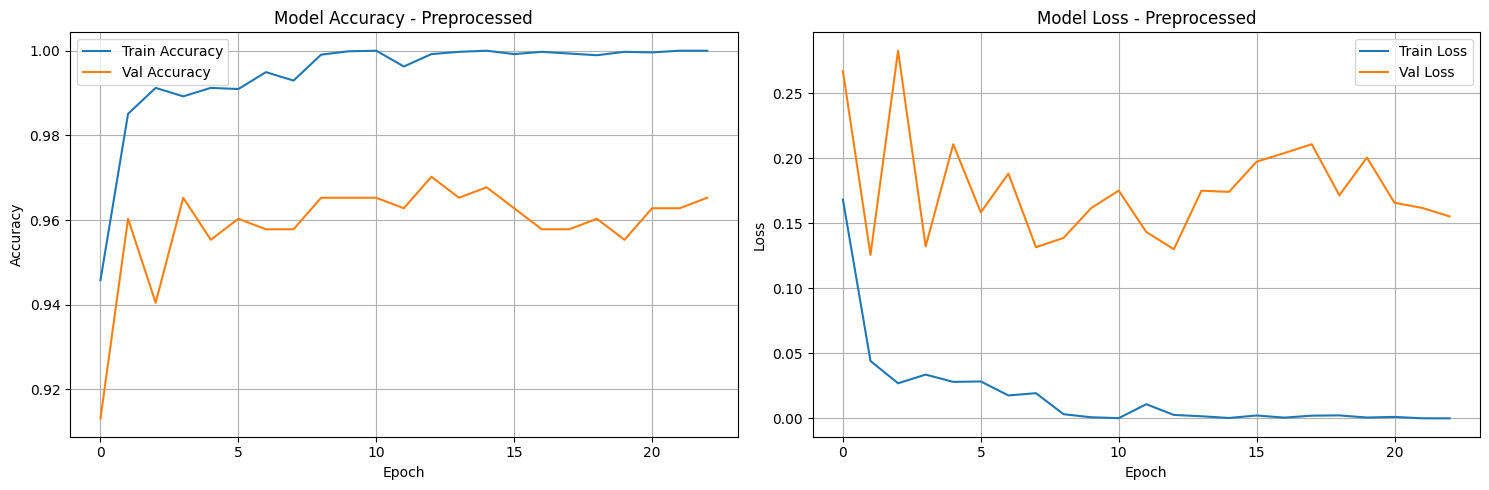


Evaluating: ViT-B16 - Preprocessed



Testing: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]



Classification Report:
              precision    recall  f1-score   support

   aluminium       0.63      0.59      0.61       148
       paper       0.47      0.46      0.47       151
     plastic       0.66      0.69      0.67       234

    accuracy                           0.60       533
   macro avg       0.59      0.58      0.58       533
weighted avg       0.60      0.60      0.60       533



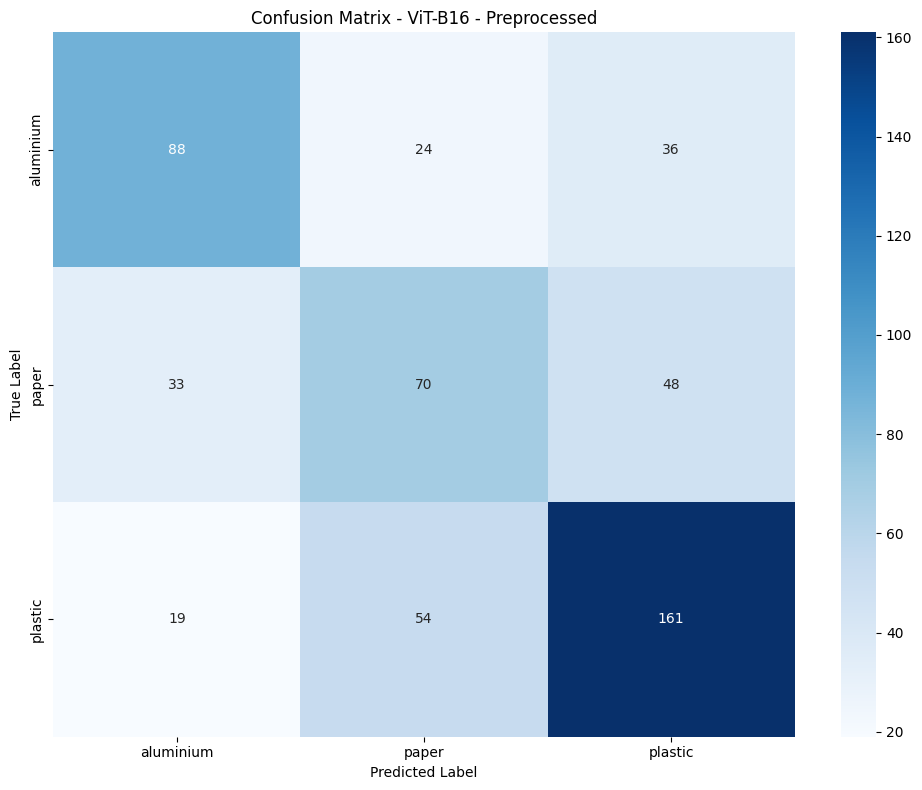


Results Summary - ViT-B16 - Preprocessed
Test Loss:      1.9326
Test Accuracy:  0.5985
Precision:      0.5970
Recall:         0.5985
F1-Score:       0.5975

✓ Results logged to results/final_results.csv
✓ Experiment 1 completed and results logged


In [8]:
print("\n" + "#"*60)
print("# EXPERIMENT 1: PREPROCESSED DATASET")
print("#"*60 + "\n")

# Create dataloaders
train_loader_prep, val_loader_prep, test_loader_prep = create_dataloaders(
    PREPROCESSED_TRAIN,
    PREPROCESSED_VAL,
    PREPROCESSED_TEST_SELF
)

# Build model
model_prep = build_vit_b16_model()
print(f"\nModel: Vision Transformer (ViT-B16)")
print(f"Total parameters: {sum(p.numel() for p in model_prep.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_prep.parameters() if p.requires_grad):,}")

# Train model
history_prep = train_model(
    model_prep,
    train_loader_prep,
    val_loader_prep,
    model_name='vit_b16_preprocessed',
    epochs=30
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_prep['train_acc'], label='Train Accuracy')
axes[0].plot(history_prep['val_acc'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Preprocessed')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_prep['train_loss'], label='Train Loss')
axes[1].plot(history_prep['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Preprocessed')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_prep = evaluate_model(model_prep, test_loader_prep, "ViT-B16 - Preprocessed")

# Log results
log_result(
    model_name='ViT-B16',
    experiment_type='Preprocessed',
    accuracy=results_prep['accuracy'],
    precision=results_prep['precision'],
    recall=results_prep['recall'],
    f1=results_prep['f1'],
    loss=results_prep['loss']
)

print("✓ Experiment 1 completed and results logged")

---
## 9. Experiment 2: Raw Dataset
Train on raw public data, test on raw self-collected data


############################################################
# EXPERIMENT 2: RAW DATASET
############################################################

Dataset sizes:
  Training:   2147 images
  Validation: 537 images
  Testing:    533 images

Training Vision Transformer (ViT-B16)



Epoch 1/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.57it/s, loss=0.3256, acc=97.02%]



Epoch 1/30:
  Train Loss: 0.2713, Train Acc: 0.9087
  Val Loss:   0.0821, Val Acc:   0.9702
  ✓ Best model saved (Val Acc: 0.9702)



Epoch 2/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.50it/s, loss=0.1941, acc=96.28%]



Epoch 2/30:
  Train Loss: 0.0685, Train Acc: 0.9776
  Val Loss:   0.1290, Val Acc:   0.9628



Epoch 3/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.57it/s, loss=0.0434, acc=96.65%]



Epoch 3/30:
  Train Loss: 0.0411, Train Acc: 0.9893
  Val Loss:   0.1137, Val Acc:   0.9665



Epoch 4/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.54it/s, loss=0.0653, acc=97.21%]



Epoch 4/30:
  Train Loss: 0.0340, Train Acc: 0.9898
  Val Loss:   0.0941, Val Acc:   0.9721
  ✓ Best model saved (Val Acc: 0.9721)



Epoch 5/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.40it/s, loss=0.0204, acc=97.21%]



Epoch 5/30:
  Train Loss: 0.0133, Train Acc: 0.9967
  Val Loss:   0.1101, Val Acc:   0.9721



Epoch 6/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.58it/s, loss=0.0156, acc=97.77%]



Epoch 6/30:
  Train Loss: 0.0396, Train Acc: 0.9884
  Val Loss:   0.0788, Val Acc:   0.9777
  ✓ Best model saved (Val Acc: 0.9777)



Epoch 7/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.50it/s, loss=0.0046, acc=98.32%]



Epoch 7/30:
  Train Loss: 0.0069, Train Acc: 0.9981
  Val Loss:   0.0673, Val Acc:   0.9832
  ✓ Best model saved (Val Acc: 0.9832)



Epoch 8/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.59it/s, loss=0.0022, acc=98.14%]



Epoch 8/30:
  Train Loss: 0.0010, Train Acc: 1.0000
  Val Loss:   0.0833, Val Acc:   0.9814



Epoch 9/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.10it/s, loss=0.0016, acc=98.32%]



Epoch 9/30:
  Train Loss: 0.0005, Train Acc: 1.0000
  Val Loss:   0.0859, Val Acc:   0.9832



Epoch 10/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.59it/s, loss=0.0013, acc=98.14%]



Epoch 10/30:
  Train Loss: 0.0004, Train Acc: 1.0000
  Val Loss:   0.0877, Val Acc:   0.9814



Epoch 11/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.62it/s, loss=0.0011, acc=98.14%]



Epoch 11/30:
  Train Loss: 0.0003, Train Acc: 1.0000
  Val Loss:   0.0895, Val Acc:   0.9814



Epoch 12/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.07it/s, loss=0.0009, acc=98.14%]



Epoch 12/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.0912, Val Acc:   0.9814



Epoch 13/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.63it/s, loss=0.0008, acc=98.14%]



Epoch 13/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.0933, Val Acc:   0.9814



Epoch 14/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.66it/s, loss=0.0007, acc=98.14%]



Epoch 14/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.0942, Val Acc:   0.9814



Epoch 15/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.65it/s, loss=0.0007, acc=98.14%]



Epoch 15/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.0953, Val Acc:   0.9814



Epoch 16/30 [Val]  : 100%|██████████| 34/34 [00:06<00:00,  5.48it/s, loss=0.0007, acc=98.14%]



Epoch 16/30:
  Train Loss: 0.0002, Train Acc: 1.0000
  Val Loss:   0.0961, Val Acc:   0.9814



Epoch 17/30 [Val]  : 100%|██████████| 34/34 [00:05<00:00,  5.68it/s, loss=0.0006, acc=98.14%]



Epoch 17/30:
  Train Loss: 0.0001, Train Acc: 1.0000
  Val Loss:   0.0969, Val Acc:   0.9814

  Early stopping triggered after 17 epochs

✓ Training completed. Best Val Acc: 0.9832


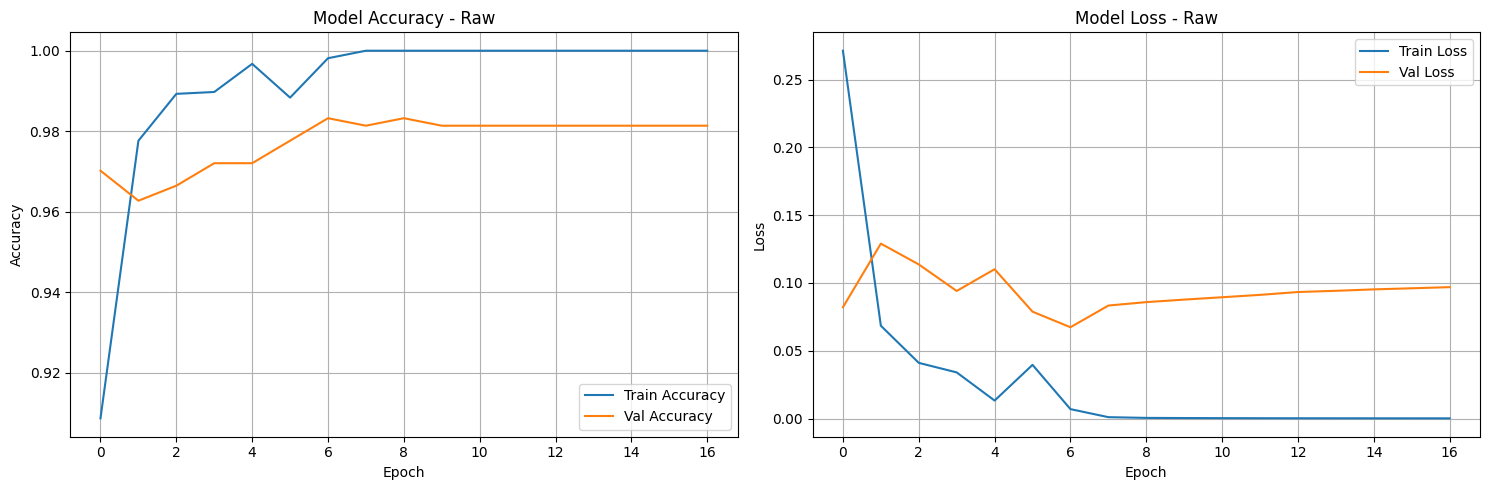


Evaluating: ViT-B16 - Raw



Testing: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]



Classification Report:
              precision    recall  f1-score   support

   aluminium       0.74      0.78      0.76       148
       paper       0.67      0.59      0.63       151
     plastic       0.74      0.77      0.76       234

    accuracy                           0.72       533
   macro avg       0.72      0.72      0.72       533
weighted avg       0.72      0.72      0.72       533



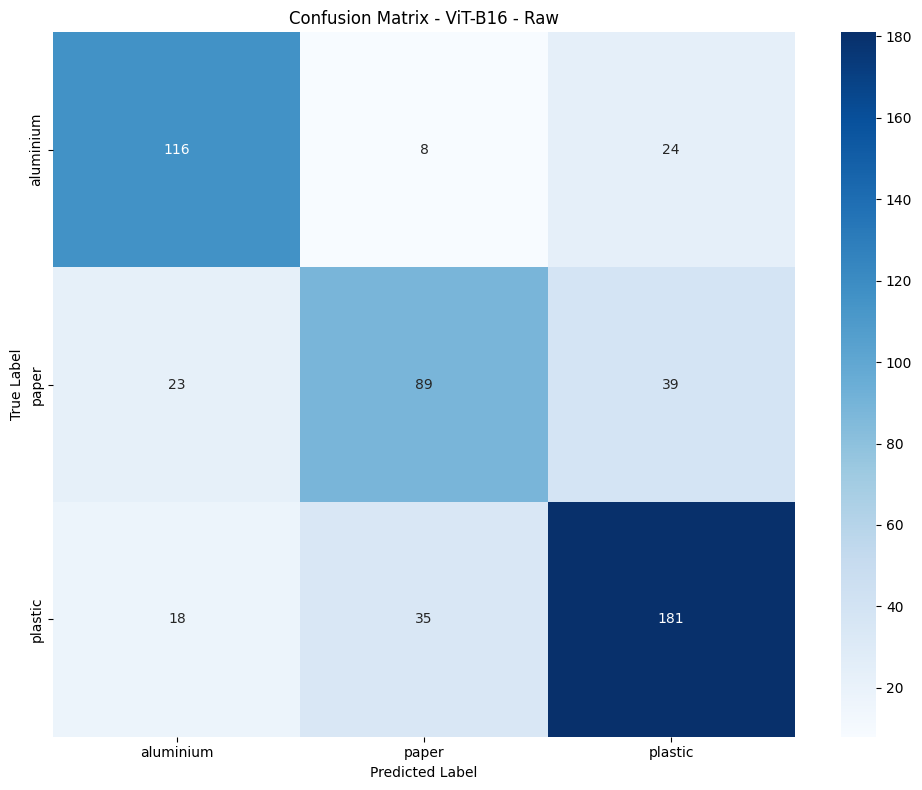


Results Summary - ViT-B16 - Raw
Test Loss:      1.1055
Test Accuracy:  0.7242
Precision:      0.7218
Recall:         0.7242
F1-Score:       0.7219

✓ Results logged to results/final_results.csv
✓ Experiment 2 completed and results logged


In [9]:
print("\n" + "#"*60)
print("# EXPERIMENT 2: RAW DATASET")
print("#"*60 + "\n")

# For raw data, we'll use 80-20 split for train-val from RAW_PUBLIC
from torch.utils.data import random_split

# Load full raw public dataset
raw_public_dataset = datasets.ImageFolder(RAW_PUBLIC, transform=train_transform)
train_size = int(0.8 * len(raw_public_dataset))
val_size = len(raw_public_dataset) - train_size
train_dataset_raw, val_dataset_raw = random_split(
    raw_public_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Update validation dataset transform
val_dataset_raw.dataset.transform = val_test_transform

# Load test dataset
test_dataset_raw = datasets.ImageFolder(RAW_SELF, transform=val_test_transform)

# Create dataloaders
train_loader_raw = DataLoader(
    train_dataset_raw, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader_raw = DataLoader(
    val_dataset_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader_raw = DataLoader(
    test_dataset_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

print(f"Dataset sizes:")
print(f"  Training:   {len(train_dataset_raw)} images")
print(f"  Validation: {len(val_dataset_raw)} images")
print(f"  Testing:    {len(test_dataset_raw)} images")

# Build new model
model_raw = build_vit_b16_model()

# Train model
history_raw = train_model(
    model_raw,
    train_loader_raw,
    val_loader_raw,
    model_name='vit_b16_raw',
    epochs=30
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_raw['train_acc'], label='Train Accuracy')
axes[0].plot(history_raw['val_acc'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Raw')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_raw['train_loss'], label='Train Loss')
axes[1].plot(history_raw['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Raw')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_raw = evaluate_model(model_raw, test_loader_raw, "ViT-B16 - Raw")

# Log results
log_result(
    model_name='ViT-B16',
    experiment_type='Raw',
    accuracy=results_raw['accuracy'],
    precision=results_raw['precision'],
    recall=results_raw['recall'],
    f1=results_raw['f1'],
    loss=results_raw['loss']
)

print("✓ Experiment 2 completed and results logged")

---
## 10. Comparison Summary
Compare results from both experiments


VIT-B16 - FINAL COMPARISON
  Experiment  Accuracy  Precision   Recall  F1-Score     Loss
Preprocessed  0.598499   0.597034 0.598499  0.597466 1.932635
         Raw  0.724203   0.721844 0.724203  0.721887 1.105471



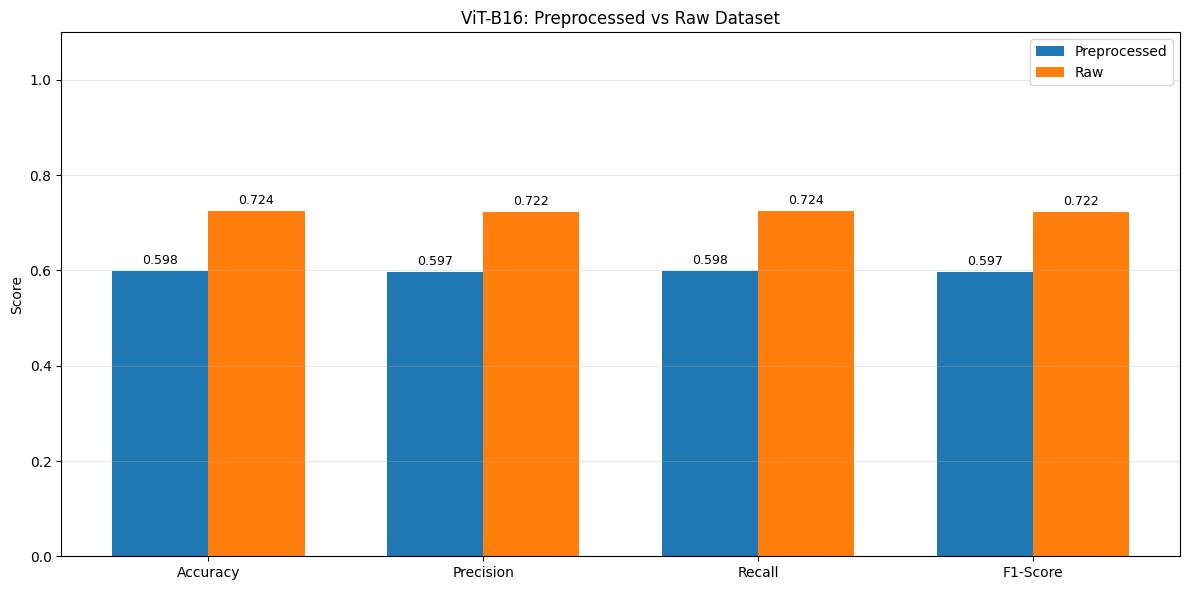


✓ All experiments completed successfully!
✓ Models saved in 'models/' directory
✓ Results logged to 'final_results.csv'


In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Experiment': ['Preprocessed', 'Raw'],
    'Accuracy': [results_prep['accuracy'], results_raw['accuracy']],
    'Precision': [results_prep['precision'], results_raw['precision']],
    'Recall': [results_prep['recall'], results_raw['recall']],
    'F1-Score': [results_prep['f1'], results_raw['f1']],
    'Loss': [results_prep['loss'], results_raw['loss']]
})

print("\n" + "="*80)
print("VIT-B16 - FINAL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2,
               [results_prep['accuracy'], results_prep['precision'],
                results_prep['recall'], results_prep['f1']],
               width, label='Preprocessed')
bars2 = ax.bar(x + width/2,
               [results_raw['accuracy'], results_raw['precision'],
                results_raw['recall'], results_raw['f1']],
               width, label='Raw')

ax.set_ylabel('Score')
ax.set_title('ViT-B16: Preprocessed vs Raw Dataset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ All experiments completed successfully!")
print("✓ Models saved in 'models/' directory")
print("✓ Results logged to 'final_results.csv'")

---
## 11. Cross-Dataset Testing: Preprocessed Model on Raw Dataset
Test the preprocessed-trained model on raw dataset to see generalization


############################################################
# CROSS-DATASET TEST: Preprocessed Model on Raw Data
############################################################

Loading preprocessed model from models/vit_b16_preprocessed.pth...
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/jiasheng/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:12<00:00, 27.5MB/s] 


✓ Model loaded successfully

Loading raw self-collected test dataset...
✓ Test dataset loaded: 533 images


Evaluating: ViT-B16 - Preprocessed Model on Raw Data



Testing: 100%|██████████| 34/34 [00:03<00:00,  9.04it/s]



Classification Report:
              precision    recall  f1-score   support

   aluminium       0.63      0.70      0.67       148
       paper       0.54      0.48      0.51       151
     plastic       0.72      0.72      0.72       234

    accuracy                           0.65       533
   macro avg       0.63      0.64      0.63       533
weighted avg       0.65      0.65      0.65       533



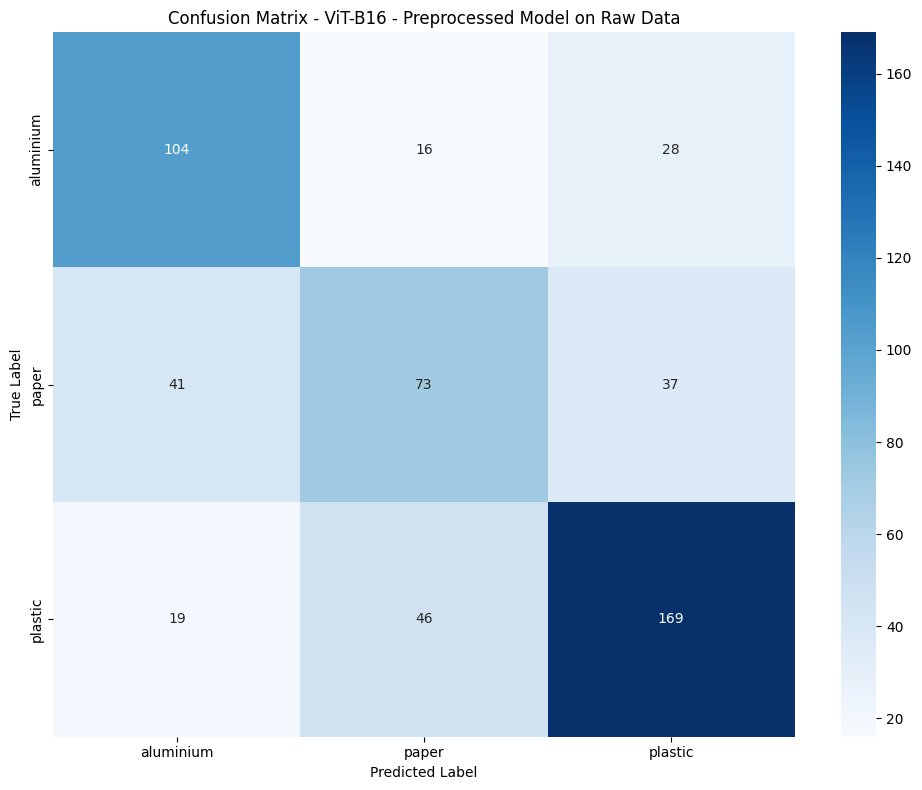


Results Summary - ViT-B16 - Preprocessed Model on Raw Data
Test Loss:      1.7289
Test Accuracy:  0.6492
Precision:      0.6464
Recall:         0.6492
F1-Score:       0.6468

✓ Results logged to results/final_results.csv

✓ Cross-dataset testing completed
This shows how the preprocessed-trained model generalizes to raw data


In [2]:
# ============================================================
# STANDALONE CROSS-DATASET TEST
# This cell can run independently if you have a trained model
# ============================================================

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Configuration
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 4
RAW_SELF = r"../Dataset/SelfCollected_Dataset"

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Test transform
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Model builder function
def build_vit_b16_model():
    weights = ViT_B_16_Weights.DEFAULT
    model = models.vit_b_16(weights=weights)
    num_features = model.heads.head.in_features
    model.heads.head = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    model = model.to(device)
    return model

# Evaluation function
def evaluate_model(model, test_loader, experiment_name):
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Logging function
def log_result(model_name, experiment_type, accuracy, precision, recall, f1, loss):
    results_file = 'results/final_results.csv'
    os.makedirs('results', exist_ok=True)
    
    result_data = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': model_name,
        'experiment_type': experiment_type,
        'accuracy': f'{accuracy:.4f}',
        'precision': f'{precision:.4f}',
        'recall': f'{recall:.4f}',
        'f1_score': f'{f1:.4f}',
        'loss': f'{loss:.4f}'
    }
    
    if os.path.exists(results_file):
        df = pd.read_csv(results_file)
        df = pd.concat([df, pd.DataFrame([result_data])], ignore_index=True)
    else:
        df = pd.DataFrame([result_data])
    
    df.to_csv(results_file, index=False)
    print(f"✓ Results logged to {results_file}")

# ============================================================
# MAIN CROSS-DATASET TEST
# ============================================================

print("\n" + "#"*60)
print("# CROSS-DATASET TEST: Preprocessed Model on Raw Data")
print("#"*60 + "\n")

# Check if preprocessed model exists
model_path = 'models/vit_b16_preprocessed.pth'
if not os.path.exists(model_path):
    print(f"❌ Model not found at {model_path}")
    print("Please run Experiment 1 (Preprocessed Dataset) first to train the model.")
else:
    # Load the preprocessed model
    print(f"Loading preprocessed model from {model_path}...")
    model_cross = build_vit_b16_model()
    model_cross.load_state_dict(torch.load(model_path, map_location=device))
    model_cross.eval()
    print("✓ Model loaded successfully\n")
    
    # Create raw test dataloader independently
    print("Loading raw self-collected test dataset...")
    test_dataset_cross = datasets.ImageFolder(RAW_SELF, transform=val_test_transform)
    test_loader_cross = DataLoader(
        test_dataset_cross,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    print(f"✓ Test dataset loaded: {len(test_dataset_cross)} images\n")
    
    # Evaluate preprocessed model on raw dataset
    results_cross = evaluate_model(
        model_cross,
        test_loader_cross,
        "ViT-B16 - Preprocessed Model on Raw Data"
    )
    
    # Log results
    log_result(
        model_name='ViT-B16',
        experiment_type='Preprocessed_on_Raw',
        accuracy=results_cross['accuracy'],
        precision=results_cross['precision'],
        recall=results_cross['recall'],
        f1=results_cross['f1'],
        loss=results_cross['loss']
    )
    
    print("\n✓ Cross-dataset testing completed")
    print("This shows how the preprocessed-trained model generalizes to raw data")
